__Data__: NYC Taxi Data<br>
__Tasks__: Trip Analysis by:
- Distance 
- Pick up time
- Major destination/pick up points - Airport
- Intra and inter borough traffic analysis

In [2]:
import findspark
findspark.init()
import pyspark
import re
from random import random
from pyspark import SparkContext
from operator import add

In [3]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.mllib.clustering import KMeans, KMeansModel

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# config = pyspark.SparkConf().set('spark.executor.memory', '512M').set('spark.cores.max', '2')\
#             .set('spark.port.maxRetries','200') 
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '10')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]
sc = pyspark.SparkContext(appName="FP baskets", master='',conf = config )

4214 rus217


In [6]:
data = sc.textFile("/scratch/ISE495/2018_project_01/green_tripdata_2015-09.csv")
data.take(5)

[u'2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979484558105469,40.684955596923828,-73.97943115234375,40.685020446777344,1,.00,7.8,0,0,1.95,0,,0,9.75,1,2',
 u'2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010795593261719,40.912216186523438,-74.010780334472656,40.912212371826172,1,.00,45,0,0,0,0,,0,45,1,2',
 u'2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921409606933594,40.766708374023438,-73.914413452148438,40.764686584472656,1,.59,4,0.5,0.5,0.5,0,,0.3,5.8,1,1',
 u'2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.92138671875,40.766677856445313,-73.931427001953125,40.771583557128906,1,.74,5,0.5,0.5,0,0,,0.3,6.3,2,1',
 u'2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482482910156,40.714046478271484,-73.944412231445313,40.714729309082031,1,.61,5,0.5,0.5,0,0,,0.3,6.3,2,1']

In [7]:
headers = "/scratch/ISE495/2018_project_01/header.txt"
head=[]
with open(headers) as f:
    a = f.readlines()
    print a
    for i in a:
        head = i.strip('\n').split(',')
    

['VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type\n']


In [8]:
l = data.take(1)
for i in l:
    a=i.split(',')
    print a

[u'2', u'2015-09-01 00:02:34', u'2015-09-01 00:02:38', u'N', u'5', u'-73.979484558105469', u'40.684955596923828', u'-73.97943115234375', u'40.685020446777344', u'1', u'.00', u'7.8', u'0', u'0', u'1.95', u'0', u'', u'0', u'9.75', u'1', u'2']


In [9]:
head
zip(head,range(0,21,1))

[('VendorID', 0),
 ('lpep_pickup_datetime', 1),
 ('Lpep_dropoff_datetime', 2),
 ('Store_and_fwd_flag', 3),
 ('RateCodeID', 4),
 ('Pickup_longitude', 5),
 ('Pickup_latitude', 6),
 ('Dropoff_longitude', 7),
 ('Dropoff_latitude', 8),
 ('Passenger_count', 9),
 ('Trip_distance', 10),
 ('Fare_amount', 11),
 ('Extra', 12),
 ('MTA_tax', 13),
 ('Tip_amount', 14),
 ('Tolls_amount', 15),
 ('Ehail_fee', 16),
 ('improvement_surcharge', 17),
 ('Total_amount', 18),
 ('Payment_type', 19),
 ('Trip_type', 20)]

In [11]:
total_trips = data.count()

### Distance Travelled

In [14]:
hist2 =  data.map(lambda x:float(x.split(',')[10])).collect()

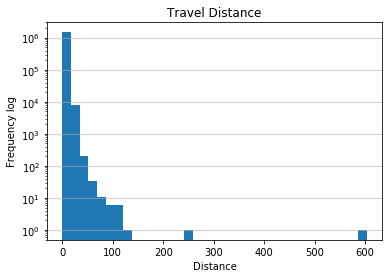

In [209]:
plt.hist(hist2,bins=35,log=1)
plt.title('Travel Distance')
plt.xlabel('Distance')
plt.axis('auto')
plt.ylabel('Frequency log')
plt.grid(axis='y', alpha=0.75)
plt.savefig('Histogram')

Percentage of rides less than 10 miles 96 %
Percentage of rides less than 2 miles 50 %


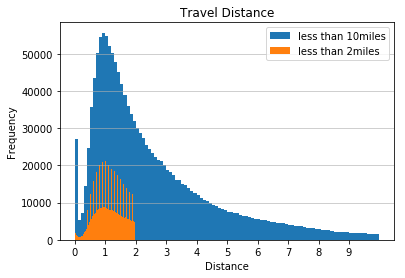

In [214]:

hist3 = sorted(i for i in hist2 if i<10)
print 'Percentage of rides less than 10 miles',len(hist3)*100/len(hist2),'%'
plt.hist(hist3,bins=100,label = 'less than 10miles')
plt.hist(hist4,bins=100,label = 'less than 2miles')
plt.title('Travel Distance')
plt.xlabel('Distance')
plt.axis('auto')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(0,10, 1))
plt.legend()
hist4 = sorted(i for i in hist2 if i<2)
print 'Percentage of rides less than 2 miles',len(hist4)*100/len(hist2),'%'
plt.savefig('Less than 10miles')
plt.show()


#### Analysis by pick up time

In [17]:
def hour_dist(x):  
    x = x.split(',')
    stamp = x[1]
    dist = x[10]
    time = stamp.split(" ")[1]
    hour = time.split(':')[0]
    return (int(float((hour))),(float(dist)))

hour_dist = data.map(hour_dist)

In [18]:
hour_dist.take(10)

[(0, 0.0),
 (0, 0.0),
 (0, 0.59),
 (0, 0.74),
 (0, 0.61),
 (0, 1.07),
 (0, 1.43),
 (0, 0.9),
 (0, 1.33),
 (0, 0.84)]

In [19]:
#Created a list of counts by each hours
count_hour = dict(hour_dist.countByKey())

In [20]:
#(hour_of_the_day,number_of _trips)
count_hour

{0: 67158,
 1: 53773,
 2: 41196,
 3: 31640,
 4: 26424,
 5: 16700,
 6: 22667,
 7: 41978,
 8: 58965,
 9: 62027,
 10: 57468,
 11: 56791,
 12: 57828,
 13: 57477,
 14: 66664,
 15: 73777,
 16: 79157,
 17: 88022,
 18: 97245,
 19: 96141,
 20: 90785,
 21: 86543,
 22: 84705,
 23: 79795}

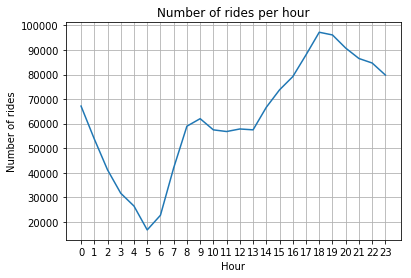

In [219]:
plt.xticks(np.arange(0,24,1))
plt.grid(axis='both')
plt.title('Number of rides per hour')
plt.xlabel('Hour')
plt.ylabel('Number of rides')
plt.plot(count_hour.values())
plt.savefig('Rides_day')
plt.show()

In [23]:
sums = hour_dist.reduceByKey(lambda x,y:round((x+y),2)).sortByKey().collect()

__Calculating the mean distance travelled per hour.__ 
- Dividing total distance travelled in that hour by the total number of rides in that hour.

In [24]:
means = {}
for i in sums:
    means[i[0]]=round(i[1]/count_hour[i[0]],2)
means

{0: 3.12,
 1: 3.02,
 2: 3.05,
 3: 3.21,
 4: 3.53,
 5: 4.13,
 6: 4.06,
 7: 3.28,
 8: 3.05,
 9: 3.0,
 10: 2.94,
 11: 2.91,
 12: 2.9,
 13: 2.88,
 14: 2.86,
 15: 2.86,
 16: 2.78,
 17: 2.68,
 18: 2.65,
 19: 2.72,
 20: 2.78,
 21: 3.0,
 22: 3.19,
 23: 3.19}

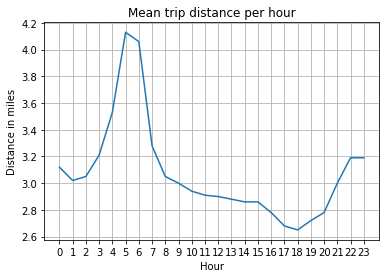

In [6]:
plt.xticks(np.arange(0,24,1))
plt.grid(axis='both')
plt.title('Mean trip distance per hour')
plt.xlabel('Hour')
plt.ylabel('Distance in miles')
plt.plot(means.values())
plt.show()

####  NYC Airport Trips


1. Which airport is more used?
2. Which airport is expensive to reach?
3. Do driver get better tips because of luggage?
4. Drop-off Time with maximum and minimum trips : Let's look what time is busiest
5. Type of Payment

Since the Ratecode for JFK is 2 and Newark is 3, we will filter entries with RateCodeID = 2 or 3


In [25]:
airport = data.filter(lambda x:(int(float(x.split(',')[4]))==2) | (int(float(x.split(',')[4]))==3))
count = airport.count()
jfk = airport.filter(lambda x:(int(float(x.split(',')[4]))==2)).count()
ewr = airport.filter(lambda x:(int(float(x.split(',')[4]))==3)).count()

In [26]:
print "Total Number of trips to JFK or Newark Airports is", count
print 'Rides to Newark:' ,ewr
print 'Rides to JFK:',jfk

Total Number of trips to JFK or Newark Airports is 5552
Rides to Newark: 1117
Rides to JFK: 4435


In [27]:
airport.take(3)

[u'2,2015-09-01 00:07:12,2015-09-01 00:07:27,N,2,-73.844268798828125,40.755165100097656,-73.844650268554687,40.755058288574219,1,.00,52,0,0.5,0,0,,0.3,52.8,2,1',
 u'2,2015-09-01 00:21:08,2015-09-01 00:21:12,N,2,-73.930213928222656,40.6776123046875,-73.930213928222656,40.67767333984375,1,.00,52,0,0.5,0,0,,0.3,52.8,2,1',
 u'2,2015-09-01 00:14:55,2015-09-01 00:15:11,N,2,-73.94671630859375,40.714317321777344,-73.944953918457031,40.714466094970703,2,.03,52,0,0.5,0,0,,0.3,52.8,2,1']

In [28]:
def airport_prices(x):
    x=x.split(',')
    code = x[4]
    passenger = x[9]
    distance = x[10]
    fare = x[11]
    tip = x[14]
    total = x[18]
    trip_type = x[20]
    return (int(float(code)),int(float(passenger)),float(distance),float(fare),float(tip),float(total),int(float(trip_type)))

airport_details = airport.map(airport_prices)

In [29]:
airport_details.take(10)

[(2, 1, 0.0, 52.0, 0.0, 52.8, 1),
 (2, 1, 0.0, 52.0, 0.0, 52.8, 1),
 (2, 2, 0.03, 52.0, 0.0, 52.8, 1),
 (2, 2, 0.03, -52.0, 0.0, -52.8, 1),
 (2, 2, 0.12, 52.0, 0.0, 52.8, 1),
 (2, 1, 0.02, 52.0, 0.0, 52.8, 1),
 (2, 1, 0.26, 52.0, 0.0, 52.8, 1),
 (2, 6, 0.0, 52.0, 0.0, 52.8, 1),
 (2, 1, 17.99, 52.0, 0.0, 58.34, 1),
 (2, 1, 20.06, 52.0, 8.0, 66.34, 1)]

In [30]:
average_fare = airport_details.map(lambda x: (x[0],x[5]) if x[0]==2 else (x[0],x[5])).reduceByKey(lambda x,y:x+y).collect()

In [31]:
average_fare

[(2, 250718.12999999907), (3, 66903.02000000002)]

In [32]:
allride_fare = data.map(lambda x:float(x.split(',')[18])).reduce(lambda x,y : x+y)
average_fare_all = allride_fare/total_trips

In [33]:
All_average = (round((average_fare[0][1]+average_fare[1][1])/count,2))
JFK_average = (round((average_fare[0][1])/jfk,2))
EWR_average = (round((average_fare[1][1])/ ewr,2))

In [34]:
print 'Average all ride fare:$', round(average_fare_all,2)
print 'Average Fare for both airports: $',All_average
print 'Average Fare for JFK:$', JFK_average
print 'Average Fare for Newark: $',EWR_average

Average all ride fare:$ 15.03
Average Fare for both airports: $ 57.21
Average Fare for JFK:$ 56.53
Average Fare for Newark: $ 59.9


In [35]:
average_tip = airport_details.map(lambda x: (x[0],x[4]) if x[0]==2 else (x[0],x[4])).reduceByKey(lambda x,y:x+y).collect()
All_average_tip = (round((average_tip[0][1]+average_tip[1][1])/ count,2))
JFK_average_tip = (round((average_tip[0][1])/jfk,2))
EWR_average_tip = (round((average_tip[1][1])/ewr,2))

In [37]:
allride_tip = data.map(lambda x:float(x.split(',')[14])).reduce(lambda x,y : x+y)
average_tip_all = allride_tip/total_trips

In [39]:
print 'Average all ride tip:', round(average_tip_all,2)
print 'Average tip for both airports: ',All_average_tip
print 'Average tip for JFK:', JFK_average_tip
print 'Average tip for Newark: ',EWR_average_tip

Average all ride tip: 1.24
Average tip for both airports:  4.35
Average tip for JFK: 4.08
Average tip for Newark:  5.44


In [40]:
def hour_trips(x):  
    x = x.split(',')
    stamp = x[1]
    code = x[4]
    time = stamp.split(" ")[1]
    hour = time.split(':')[0]
    return (int(float((hour))),int(float(code)))


hour_airport_trip = data.map(hour_trips)

In [41]:
ewr_hours = dict(hour_airport_trip.filter(lambda x:x[1]==3).countByKey())
jfk_hours = dict(hour_airport_trip.filter(lambda x:x[1]==2).countByKey())

In [42]:
print 'Trips by Hours to Newark (hours, number of trips, % of total trips to newark)'
ewr_hours
ewr_hours_perc = {}
for items in ewr_hours.items():   
    ewr_hours_perc[items[0]] = (ewr_hours[items[0]],round(items[1]*100.00/ewr,2))

ewr_hours_perc

Trips by Hours to Newark (hours, number of trips, % of total trips to newark)


{0: (22, 1.97),
 1: (23, 2.06),
 2: (16, 1.43),
 3: (16, 1.43),
 4: (48, 4.3),
 5: (33, 2.95),
 6: (36, 3.22),
 7: (52, 4.66),
 8: (42, 3.76),
 9: (48, 4.3),
 10: (44, 3.94),
 11: (51, 4.57),
 12: (74, 6.62),
 13: (60, 5.37),
 14: (83, 7.43),
 15: (87, 7.79),
 16: (72, 6.45),
 17: (76, 6.8),
 18: (61, 5.46),
 19: (41, 3.67),
 20: (40, 3.58),
 21: (28, 2.51),
 22: (29, 2.6),
 23: (35, 3.13)}

In [222]:
print 'Trips by Hours to JFk (hours, number of trips, % of total trips to JFK)'
jfk_hours
jfk_hours_perc = {}
for items in jfk_hours.items():   
    jfk_hours_perc[items[0]] = (jfk_hours[items[0]],round(items[1]*100.00/jfk,2))

jfk_hours_perc


Trips by Hours to JFk (hours, number of trips, % of total trips to JFK)


{0: (80, 1.8),
 1: (58, 1.31),
 2: (51, 1.15),
 3: (69, 1.56),
 4: (93, 2.1),
 5: (131, 2.95),
 6: (159, 3.59),
 7: (165, 3.72),
 8: (206, 4.64),
 9: (207, 4.67),
 10: (205, 4.62),
 11: (217, 4.89),
 12: (223, 5.03),
 13: (243, 5.48),
 14: (286, 6.45),
 15: (356, 8.03),
 16: (337, 7.6),
 17: (285, 6.43),
 18: (272, 6.13),
 19: (232, 5.23),
 20: (179, 4.04),
 21: (132, 2.98),
 22: (122, 2.75),
 23: (127, 2.86)}

In [44]:
plot_jfk = {}
for i in jfk_hours_perc.items():
    plot_jfk[i[0]]=float(i[1][1])

plot_ewr = {}
for i in ewr_hours_perc.items():
    plot_ewr[i[0]]=float(i[1][1])

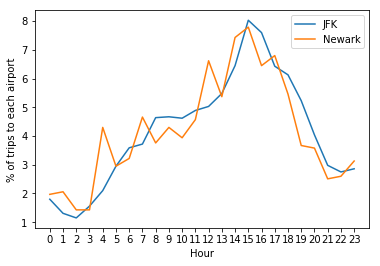

In [223]:
plt.plot(plot_jfk.values(),label='JFK') 
plt.plot(plot_ewr.values(),label='Newark')
plt.legend()
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hour')
plt.ylabel('% of trips to each airport')
plt.savefig('Airport Trips')
plt.show()

In [46]:
def pay(x):
    x = x.split(',')
    return (int(float(x[4])),int(float(x[19])))

payment = data.map(pay)

In [47]:
ewr_payment = dict(payment.filter(lambda x: x[0]==3).countByValue())
ewr_payment

{(3, 1): 460, (3, 2): 499, (3, 3): 110, (3, 4): 47, (3, 5): 1}

In [48]:
jfk_payment = dict(payment.filter(lambda x: x[0]==2).countByValue())
jfk_payment

{(2, 1): 1740, (2, 2): 2498, (2, 3): 138, (2, 4): 58, (2, 5): 1}

#### Intra and Inter Borough Traffic Analysis
New Jersey Code :1
New York Code:2

In [261]:
def trips(x):
    x = x.split(',')
    for i in range(4,9,1):
        x[i]=float(x[i])
    if x[6] > 1.323942*x[5]+138.669195:
        start = 1
    else:
        start =2
    if x[8] > 1.323942*x[7]+138.669195:
        end =1
    else:
        end=2
    return ((x[5],x[6]),(x[7],x[8]),(start,end))
rides = data.map(trips)

In [262]:
counts = rides.collect()

In [268]:
NJ_NJ =0
NJ_NY = 0
NY_NY = 0
NY_NJ =0
for j in counts:
        i = j[2]
        if i[0] == 1:
            if i[0]==i[1]:
                NJ_NJ +=1
            else:
                NJ_NY +=1
        else:
            if i[0]==i[1]:
                NY_NY +=1
            else:
                NY_NJ +=1

ride_analysis = (NJ_NJ,NJ_NY,NY_NY,NY_NJ)

In [307]:
print 'The rides are bifurcated as follows:\nNJ to NJ:',NJ_NJ,'or', float(NJ_NJ*100/total_trips),"%"
print 'NJ to NY: ',NJ_NY,'or', float(NJ_NY*100/total_trips),"%"
print'NY to NY: ',NY_NY,'or', float(NY_NY*100/total_trips),"%"
print'NY to NJ: ',NY_NJ,'or', float(NY_NJ*100/total_trips),"%"

The rides are bifurcated as follows:
NJ to NJ: 449130 or 30.0 %
NJ to NY:  37133 or 2.0 %
NY to NY:  864553 or 57.0 %
NY to NJ:  144110 or 9.0 %


In [276]:
uptown_downtown = 0
downtown_uptown = 0
for i in counts:
    if i[2][0]==i[2][1]==2:
        if i[0][1] > i[1][1]:
            downtown_uptown +=1
        else:
            uptown_downtown +=1
            

In [277]:
print "Within New York Total Rides:",uptown_downtown+downtown_uptown,'\n Uptown to Downtown Rides:',uptown_downtown,'\n Downtown to Uptown Rides: ',downtown_uptown

Within New York Total Rides: 864553 
 Uptown to Downtown Rides: 398428 
 Downtown to Uptown Rides:  466125


In [49]:
#Days and time 
def info(x):
    x = x.split(',')
    vendor = x[0]
    stamp = x[1].split(" ")
    dist = x[10]
    day=stamp[0]
    time = stamp[1]
    hour = time.split(':')[0]
    Store_and_fwd_flag = x[3]
    rate = x[4]
    Pickup_longitude = x[5]
    Pickup_latitude=x[6]
    Dropoff_longitude=x[7]
    Dropoff_latitude=x[8]
    Passenger_count=x[9]
    Trip_distance=x[10]
    Fare_amount=x[11]
    Extra=x[12]
    MTA_tax=x[13]
    Tip_amount=x[14]
    Tolls_amount=x[15]
    Ehail_fee=x[16]
    improvement_surcharge=x[17]
    Total_amount=x[18]
    Payment_type=x[19]
    Trip_type=x[20]
    return(vendor,Store_and_fwd_flag,day,time,hour,rate,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type)

info1 = data.map(info)
    

In [100]:
x= info1.take(1)
x

[(u'2',
  u'N',
  u'2015-09-01',
  u'00:02:34',
  u'00',
  u'5',
  u'-73.979484558105469',
  u'40.684955596923828',
  u'-73.97943115234375',
  u'40.685020446777344',
  u'1',
  u'.00',
  u'7.8',
  u'0',
  u'0',
  u'1.95',
  u'0',
  u'',
  u'0',
  u'9.75',
  u'1',
  u'2')]

In [76]:
import datetime

In [77]:
def days(x):
    x=x.strip(" ").split('-')
    year = int(x[0])
    month = int(x[1])
    day = int(x[2])
    return (day)

days1 =info1.map(lambda x:x[2]).map(days)

In [78]:
counts_days =days1.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).collect()
counts_days= sorted(counts_days)

In [80]:
analysis = []
for i in range(1,31,1):
    x = datetime.datetime(2015,9,i)
    analysis.append(x.strftime("%A"))

In [81]:
daily_demands =[]
dates = range(0,30,1)
days = []
i = 0
for i in range(0,30,1):
    daily_demands.append(counts_days[i][1])
    days.append(str(analysis[i].lower()))
else:
    pass

In [82]:
abc = zip(analysis,daily_demands)
weekly = {}
for i in abc:
    if i[0] not in weekly:
        weekly[i[0]]=i[1]
    else: 
        weekly[i[0]]+=i[1]

In [83]:
weekly

{'Friday': 222507,
 'Monday': 165396,
 'Saturday': 259733,
 'Sunday': 220675,
 'Thursday': 191555,
 'Tuesday': 210256,
 'Wednesday': 224804}

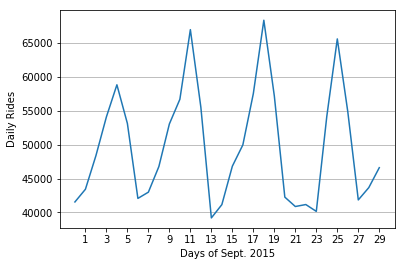

In [235]:
plt.plot(dates,daily_demands)
plt.ylabel('Daily Rides')
plt.xlabel('Days of Sept. 2015')
plt.xticks(np.arange(1,31,2))
plt.grid(axis = 'y')
plt.savefig('Monthly')
plt.show()

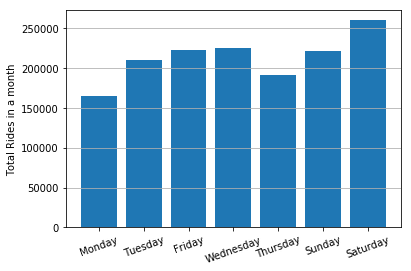

In [236]:
plt.bar(weekly.keys(),weekly.values())
plt.xticks(rotation = 20)
plt.ylabel('Total Rides in a month')
plt.grid(axis = 'y')
plt.savefig('Week')
plt.show()

In [103]:
payments = info1.flatMap(lambda x: x[20]).map(lambda r:(r,1)).reduceByKey(lambda x,y:x+y).collect()

In [107]:
payments

[(u'1', 701287), (u'2', 783699), (u'3', 5498), (u'4', 4368), (u'5', 74)]

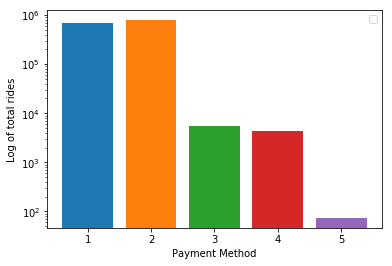

In [239]:
payments = sorted(payments)
for i in payments:
    plt.bar(i[0],i[1])
plt.legend()
plt.yscale('log')
plt.xlabel('Payment Method')
plt.ylabel('Log of total rides')
plt.savefig('Overall Payment')
plt.show()
    

In [55]:
vendors = info1.flatMap(lambda x: x[0]).map(lambda r:(r,1)).reduceByKey(lambda x,y:x+y).collect()

In [62]:
print "Vendor Distribution:\nCreative Mobile technologies:",vendors[0][1]*100/total_trips,"%\nVeriFone Inc.:",vendors[1][1]*100/total_trips,'%'

Vendor Distribution:
Creative Mobile technologies: 21 %
VeriFone Inc.: 78 %


In [91]:
rates = info1.flatMap(lambda x: x[5]).map(lambda r:(r,1)).reduceByKey(lambda x,y:x+y).collect()

In [110]:
rates

[(u'1', 1454464),
 (u'2', 4435),
 (u'3', 1117),
 (u'4', 925),
 (u'5', 33943),
 (u'6', 36),
 (u'9', 12)]

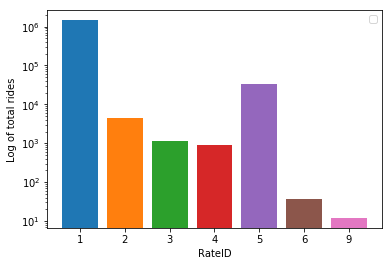

In [240]:
rates = sorted(rates)
for i in rates:
    plt.bar(i[0],i[1])
plt.legend()
plt.yscale('log')
plt.xlabel('RateID')
plt.ylabel('Log of total rides')
plt.savefig('Overall RateID')
plt.show()

In [111]:
connections = info1.flatMap(lambda x: x[1]).map(lambda r:(r,1)).reduceByKey(lambda x,y:x+y).collect()

In [112]:
connections

[(u'Y', 8734), (u'N', 1486192)]

In [113]:
passengers = info1.flatMap(lambda x: x[10]).map(lambda r:(r,1)).reduceByKey(lambda x,y:x+y).collect()

In [114]:
passengers

[(u'1', 1255832),
 (u'9', 16),
 (u'0', 440),
 (u'8', 30),
 (u'3', 33812),
 (u'2', 115014),
 (u'5', 57907),
 (u'4', 9769),
 (u'7', 15),
 (u'6', 22091)]

In [153]:
rev1 = info1.map(lambda x: [int(float(x[10])),float(x[19])])

In [199]:
passenger_counts = dict(rev1.countByKey())

In [200]:
print "Rides summarized by number of passengers:\n" 
passenger_counts

Rides summarized by number of passengers:



{0: 440,
 1: 1255832,
 2: 115014,
 3: 33812,
 4: 9769,
 5: 57907,
 6: 22091,
 7: 15,
 8: 30,
 9: 16}

In [180]:
sumCount = rev1.combineByKey(lambda value: (value, 1),
                             lambda x, value: (x[0] + value, x[1] + 1),
                             lambda x, y: (x[0] + y[0], x[1] + y[1]))

sumbykey = sumCount.map(lambda (label, (value_sum, count)): (label, int(value_sum)))
                    

revenue=sumbykey.collect()

In [181]:
sorted(revenue)

[(0, 5390),
 (1, 18733300),
 (2, 1823578),
 (3, 543574),
 (4, 158532),
 (5, 867092),
 (6, 338996),
 (7, 373),
 (8, 672),
 (9, 434)]

In [192]:
avg_pass_ride = sorted(zip(revenue,passenger_counts.values()))

In [194]:
avg_pass_ride

[((0, 5390), 440),
 ((1, 18733300), 115014),
 ((2, 1823578), 9769),
 ((3, 543574), 57907),
 ((4, 158532), 22091),
 ((5, 867092), 15),
 ((6, 338996), 30),
 ((7, 373), 16),
 ((8, 672), 1255832),
 ((9, 434), 33812)]

In [195]:
average_revenue_ride= {}
for i in avg_pass_ride:
        average_revenue_ride[i[0][0]] =round(float(i[0][1]/i[1]))
        

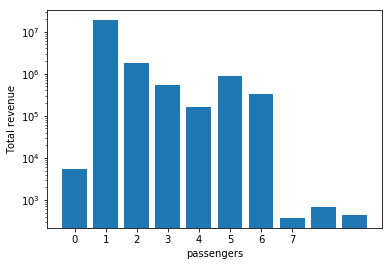

In [241]:
plt.bar(list(x[0]for x in revenue),list(x[1] for x in revenue))
plt.xticks(np.arange(0,8,1))
plt.xlabel('passengers')
plt.ylabel('Total revenue')
plt.yscale('log')
plt.savefig('Total Revenue_Pass')
plt.show()

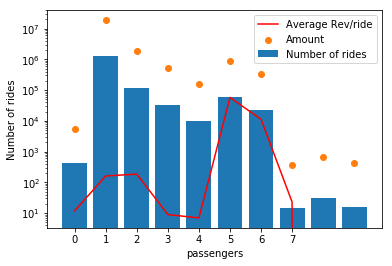

In [242]:
plt.bar(list(passenger_counts.keys()),list(passenger_counts.values()),label = 'Number of rides')
plt.scatter(list(x[0]for x in revenue),list(x[1] for x in revenue),label = 'Amount')
plt.xticks(np.arange(0,8,1))
plt.plot(list(average_revenue_ride.keys()),list(average_revenue_ride.values()),label = 'Average Rev/ride',color = 'red')
plt.legend()
plt.xlabel('passengers')
plt.ylabel('Number of rides')
plt.yscale('log')
plt.savefig('Average')
plt.show()

In [ ]:
sc.stop()